In [1]:

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1,'./src')
from grasscare import *
from GDMap import *

import numpy as np
import matplotlib.pyplot as plt

In [2]:

def GROUSE_demo_init(m, r, n_K, missing_percentages):
    U_array, labels, centers = U_array_init(ambient_dimension = m, rank = r, count = 1, clusters = 1)

    print('\n########## GROUSE initialization ##########')
    GROUSE_paths = []
    path_names = []

    labels = np.array([i for i in range(len(missing_percentages))])
    #initializing multiple GROUSE path with same starting point and target but different missing_percentage

    paths_obj = []
    for i in range(len(missing_percentages)):
        path_names.append(str(int(missing_percentages[i] * 100))  + '% missing')

        if i == 0:
            GROUSE_dict = GROUSE_init(U_array, missing_percentage = missing_percentages[i], observed_vectors = n_K)
        else:
            GROUSE_dict = GROUSE_init(U_array, missing_percentage = missing_percentages[i], observed_vectors = n_K,
                                        U_0 = GROUSE_paths[0][0], U_0_load = True)

        GROUSE_paths.append(GROUSE(GROUSE_dict, max_iter = 1, eta = 1))

        print('missing Percentage:', missing_percentages[i])
        print('\tDistance(U*, U_t) = ', d_G(U_array[0], GROUSE_paths[-1][-1]))
        
        obj_array = []
        for p_i in GROUSE_paths[-1]:
            #print(p_i.shape)
            #print(U_array[0].shape)
            obj_array.append(d_G(p_i, U_array[0]))

        paths_obj.append(obj_array)
        plt.plot(obj_array, label = path_names[i])
    
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('GROUSE training loss')
    plt.legend()
    plt.show()

    optional_params = { 'path_names': path_names, 'Targets': U_array}

    GROUSE_paths = np.array(GROUSE_paths)
    S = []
    for t in range(n_K):
        S.append(GROUSE_paths[:,t])
    S = np.array(S)

    print('S Shape:', S.shape)

    return S, labels, optional_params, paths_obj



In [3]:
data = np.load('GROUSE_Data.npz')

In [4]:
ambient_dimension = m = 200
rank = r = 5
observed_vectors = n_K = 50
missing_percentages = [0.3]


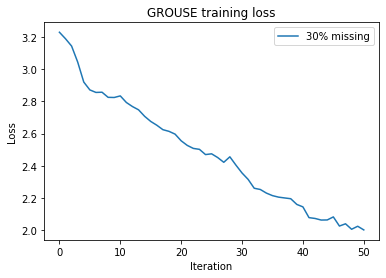

In [5]:

data = np.load('GROUSE_Data.npz', allow_pickle = True)
S = data['S']
labels = data['labels']

optional_params = data['optional_params'].item()
paths_obj = data['paths_obj']


for i,p in enumerate(paths_obj):
    plt.plot(p, label = optional_params['path_names'][i])

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('GROUSE training loss')
plt.legend()
plt.show()


In [16]:
np.savez_compressed('t-SNE',  tSNE_embedding = tSNE_embedding, tSNE_info = tSNE_info, allow_pickle = True)


######################### Grasscare 1.1.9 #########################
limit_boundary: False
Multiple Time Frames Mode: On
Reshaped S shape: (51, 200, 5)
Found the optimizer with 499 iterations!                    
Optimum Objective: 7.155664889356973


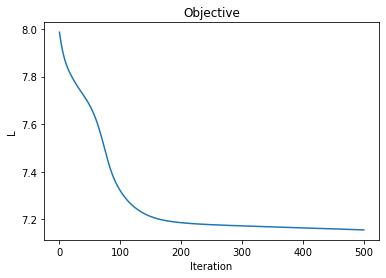

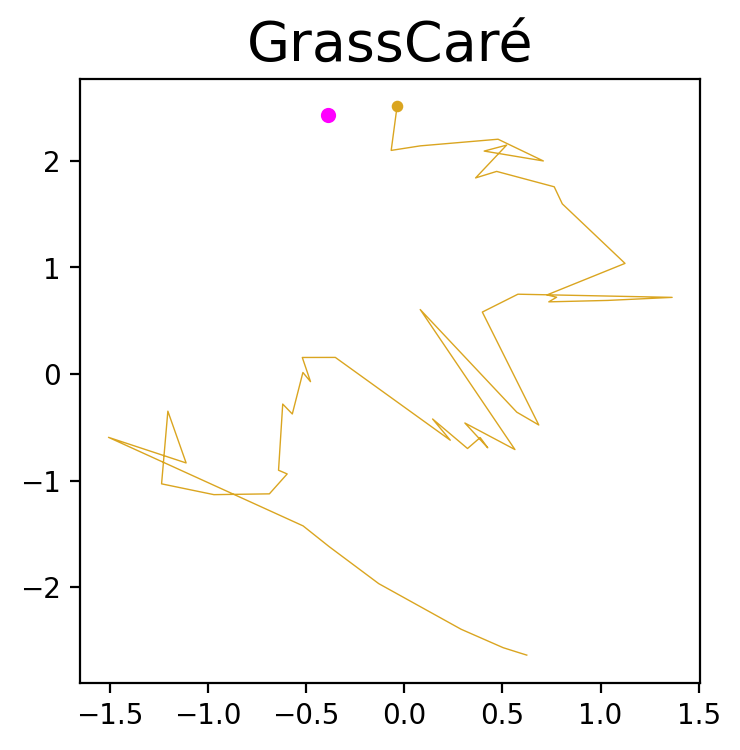

######################### Grasscare END ###########################



In [6]:
tSNE_op = optional_params.copy()

tSNE_op['embedding_method'] = 'EuclideanL2'
tSNE_op['cost_function'] = 't-SNE'
tSNE_op['color_path'] = 'goldenrod'
tSNE_op['path_names'] = []

tSNE_embedding, tSNE_info = grasscare_plot(S = S, labels = labels, video = False, optional_params = tSNE_op)


In [15]:
np.savez_compressed('GrassCare',  embedding = embedding, info = info, allow_pickle = True)


######################### Grasscare 1.1.9 #########################
limit_boundary: True
Multiple Time Frames Mode: On
Reshaped S shape: (51, 200, 5)
Found the optimizer with 326 iterations!                    
Optimum Objective: 7.140825014783104


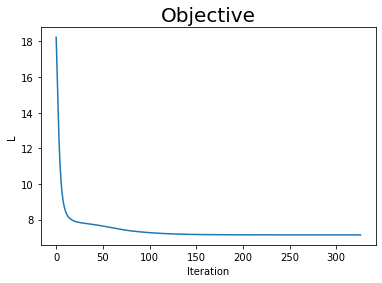

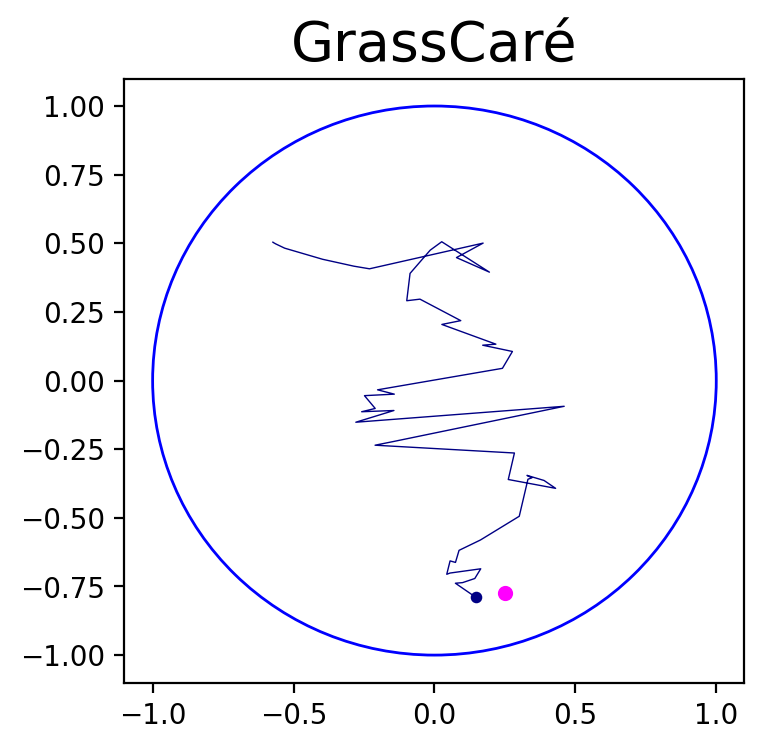

######################### Grasscare END ###########################



In [7]:

#optional_params['video_tail'] = 20
#optional_params['GoogleColab'] = True
optional_params['path_names'] = []
embedding, info = grasscare_plot(S = S, labels = labels, video = False, optional_params = optional_params)

#print(embedding)
#print(embedding.shape)


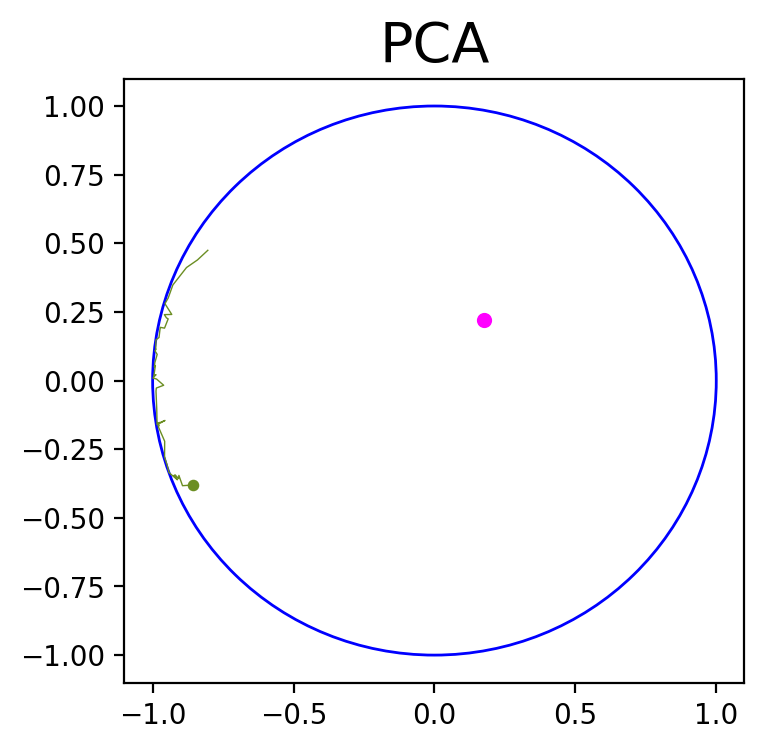

In [12]:
merged_U_array = S[:,0]
for i in range(1,S.shape[1]):
    merged_U_array = np.concatenate( (merged_U_array, S[:,i]), axis = 0 )

if 'Targets' in optional_params:
    merged_U_array = np.concatenate( (optional_params['Targets'], merged_U_array), axis = 0 )


b_array_pca = b_array_init(count = -1, style = 'PCA', U_array = merged_U_array.copy())


plot_b_array_path(b_array = b_array_pca,
                            labels = labels,
                            paths_count = S.shape[1],
                            path_length = S.shape[0],
                            targets_count = 1,
                            video = False,
                            title = 'PCA',
                            save = True,
                            plot = True,
                            format = 'pdf',
                            tail = -1,
                            #path_names = optional_params['path_names'],
                            color_path = 'olivedrab'
                            )

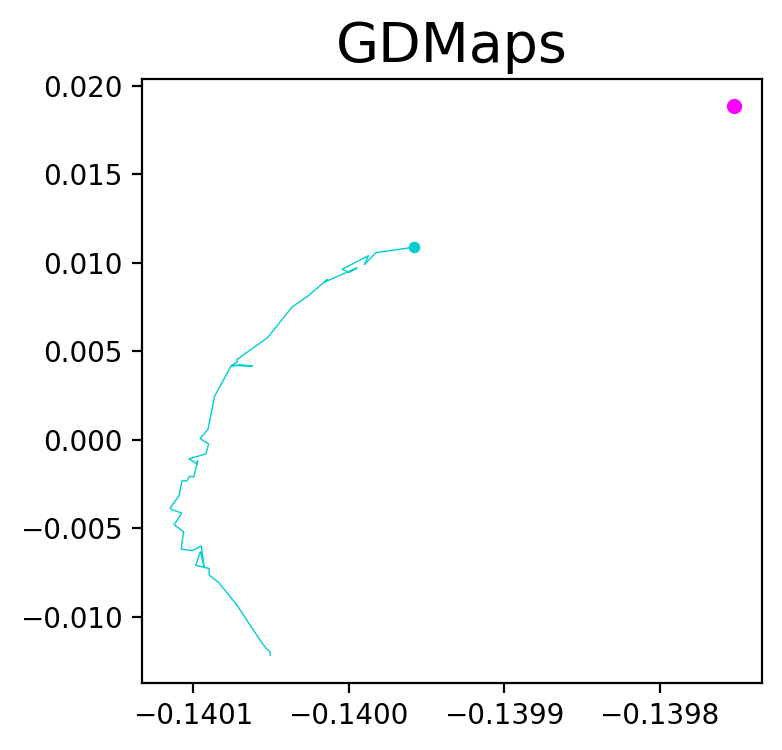

In [17]:
b_array_GDM = GDMap(U_array = merged_U_array, rank = r)


plot_b_array_path(b_array = b_array_GDM,
                            labels = labels,
                            paths_count = S.shape[1],
                            path_length = S.shape[0],
                            targets_count = 1,
                            video = False,
                            title = 'GDMaps',
                            save = True,
                            plot = True,
                            format = 'pdf',
                            tail = -1,
                            #path_names = optional_params['path_names'],
                            limit_boundary = False,
                            #boundary = [[-0.155,-0.115],[-0.017,0.023]],
                            color_path = 'darkturquoise'
                            )

In [10]:

dists = [[],[]]
for time in range(embedding.shape[0]):
    for seq in range(embedding.shape[1]):
        dists[seq].append(d_p(embedding[time, seq], info['Target'][0], method = 'Poincare'))



tSNE_dists = [[],[]]
for time in range(tSNE_embedding.shape[0]):
    for seq in range(tSNE_embedding.shape[1]):
        tSNE_dists[seq].append(d_p(tSNE_embedding[time, seq], tSNE_info['Target'][0]))

        
targets_count = 1
U_array = S
b_array = np.zeros((U_array.shape[0],U_array.shape[1],2))
for col in range(U_array.shape[1]):
    b_array[:,col] = b_array_pca[targets_count + col * U_array.shape[0] : targets_count + (col+1) * U_array.shape[0]]

target = b_array_pca[:targets_count].copy()

PCA_dists = [[],[]]
for time in range(b_array.shape[0]):
    for seq in range(b_array.shape[1]):
        PCA_dists[seq].append( np.linalg.norm(b_array[time, seq]- target) )
        
        
targets_count = 1
U_array = S
GDS_b_array = np.zeros((U_array.shape[0],U_array.shape[1],2))
for col in range(U_array.shape[1]):
    GDS_b_array[:,col] = b_array_GDM[targets_count + col * U_array.shape[0] : targets_count + (col+1) * U_array.shape[0]]

target = b_array_GDM[:targets_count].copy()

GDS_dists = [[],[]]
for time in range(GDS_b_array.shape[0]):
    for seq in range(GDS_b_array.shape[1]):
        GDS_dists[seq].append( np.linalg.norm(GDS_b_array[time, seq]- target) )


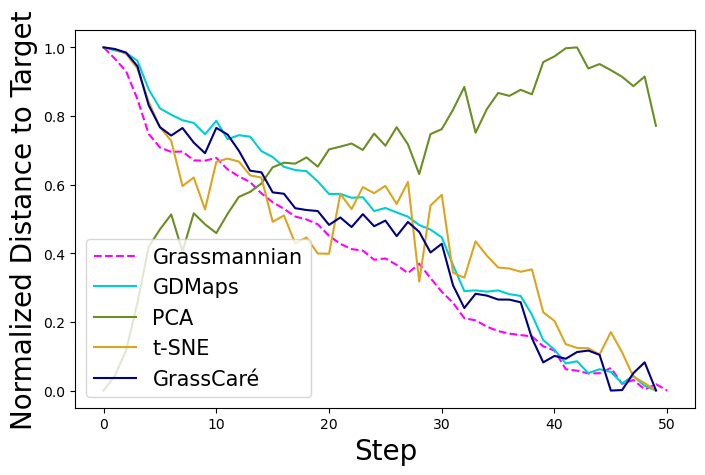

In [13]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
cmap=plt.get_cmap("jet")

plt.figure(dpi = 100, figsize= (8,5))

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


normalized_gd = paths_obj[0] - min(paths_obj[0])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd, linestyle = 'dashed',c = 'fuchsia', label = 'Grassmannian')

normalized_gd = GDS_dists[0] - min(GDS_dists[0])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd,c = 'darkturquoise', label = 'GDMaps')

normalized_gd = PCA_dists[0] - min(PCA_dists[0])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd, c = 'olivedrab',label = 'PCA')


normalized_gd = tSNE_dists[0] - min(tSNE_dists[0])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd ,c = 'goldenrod',label = 't-SNE')


normalized_gd = dists[0] - min(dists[0])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd, c = cmap(0) ,label = r'GrassCaré')



plt.ylabel('Normalized Distance to Target')
#plt.title('30%-missing data')
plt.legend()
plt.xlabel('Step')

plt.savefig('30missingdataGROUSE.pdf', format = 'pdf')
plt.show()